# 데이터 탐색 및 전처리

step1) 필요한 python 라이브러리 import

In [921]:

#################### matplotlib 한글 깨짐 현상 해결 ####################
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['axes.unicode_minus'] = False
# path = 'C:\\Windows\\Fonts\\H2GTRM.TTF'
# font_name = fm.FontProperties(fname=path, size=10).get_name()
# plt.rc('font', family=font_name)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#################### 필요한 python lib import ###########################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from sklearn.decomposition import PCA

from IPython.display import Image
import warnings
warnings.filterwarnings(action='ignore')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

## 데이터 불러오기

step2 ) segment할 데이터 불러오기(pandas의 data frame 형식으로)

* **굵은 텍스트** [olist dataset] : https://www.kaggle.com/olistbr/brazilian-ecommerce

In [922]:
df_orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_orders_dataset.csv',sep=',', parse_dates=['order_purchase_timestamp', 'order_estimated_delivery_date', 'order_delivered_customer_date'])
df_customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_customers_dataset.csv',sep=',')
df_payments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_payments_dataset.csv',sep=',')
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_reviews_dataset.csv',sep=',')
df_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_order_items_dataset.csv',sep=',')
df_products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_products_dataset.csv',sep=',')
product_translations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_category_name_translation.csv',sep=',')
df_sellers= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/olist_sellers_dataset.csv',sep=',')

In [923]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 전처리

### 고객 기준 데이터

df_products 와 product_translations 합치기 - 브라질 데이터이므로, 브라질어를 영어로 변환

In [924]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [925]:
product_translations.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [926]:
df_pd = df_products.merge(product_translations, how = 'left', left_on = 'product_category_name', right_on = 'product_category_name')
print(df_pd.columns)

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')


> df_orders 와 df_customers 합치기 - customer_unique_id 를 병합시켜준다.(하나의 customer_unique_id가 여러 customer_id를 만드는 경우 있다.) 전자상거래이므로 고객 위치 데이터 중 zip_code가 유의미하다고 판단.

In [927]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [928]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [929]:
df_customer = pd.merge(df_orders[['customer_id','order_id','order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix']], how ='inner', on ='customer_id') 
df_customer = df_customer.drop_duplicates(keep=False)
print(df_customer.columns)
print(df_customer.shape)
print(df_customer["customer_id"].duplicated().value_counts()) 

Index(['customer_id', 'order_id', 'order_purchase_timestamp',
       'customer_unique_id', 'customer_zip_code_prefix'],
      dtype='object')
(99441, 5)
False    99441
Name: customer_id, dtype: int64


> df_customer 와 df_payments 합치기 : df_customer - 결제에 대한 정보 병합

In [930]:
df_customer.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195


In [931]:
df_customer.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,59296
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,9195


In [932]:
df_customer = df_customer.merge(df_payments, how = 'inner', left_on = 'order_id', right_on = 'order_id')

In [933]:
df_customer.head()

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,payment_sequential,payment_type,payment_installments,payment_value
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,1,credit_card,1,18.12
1,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,3,voucher,1,2.00
2,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,3149,2,voucher,1,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,47813,1,boleto,1,141.46
4,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,75265,1,credit_card,3,179.12


> df_customer 를 customer_unique_id, customer_id, order_id, ord_purchase_timestamp 를 기준으로 합을 구하기 - payment_value 합을 구할 수 있는 게 핵심  

In [934]:
df_customer = df_customer.groupby(['customer_unique_id','customer_id','order_id','order_purchase_timestamp']).sum().reset_index()

In [935]:
df_customer.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,7787,1,8,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,6053,1,1,27.19
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,88115,1,8,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,66812,1,4,43.62
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,18040,1,6,196.89


In [936]:
print(df_customer.columns)
print(df_customer.shape)
print(df_customer["customer_id"].duplicated().value_counts())

Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value'],
      dtype='object')
(99440, 8)
False    99440
Name: customer_id, dtype: int64


> df_customer 와 df_items 합치기 : df_items_paid - df_products와 합치기 위해서 product_id가 있는 df_items와 먼저 병합한다.
1. 위에서 구한 payment_value 합을 통해 order_item_id가 1이 아닌 데이터들의  payment_value 을 구할 수 있다.
2. product_id 컬럼을 통해 영어로된 상품 카테고리 이름과 연결시킬 수 있다.

In [937]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [938]:
print(max(df_items['order_item_id']))

21


In [939]:
df_customer = df_customer.merge(df_items[['order_id','order_item_id', 'product_id', 'price', 'freight_value']], how = 'inner', left_on = 'order_id', right_on = 'order_id')
print(df_customer.shape)
print(df_customer["customer_id"].duplicated().value_counts())

(112647, 12)
False    98665
True     13982
Name: customer_id, dtype: int64


> df_customer_order 와 df_products 합치기 : product_id 기준으로 df_customer_order에 영어로된 상품 카테고리 이름을 병합할 수 있다.


In [940]:
df_customer = df_customer.merge(df_products[['product_id','product_category_name']], how = 'inner', left_on = 'product_id', right_on = 'product_id')

print(df_customer.shape)
print(df_customer.columns)
print(df_customer["customer_id"].duplicated().value_counts())

(112647, 13)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name'],
      dtype='object')
False    98665
True     13982
Name: customer_id, dtype: int64


> df_customer 와 df_reviews 합치기 : df_customer - 여기에서의 review_score 는 상품 각각의 score다. (구매자 입장에서 상품의 리뷰 평가점수가 영향을 미치는 경우가 많으로 해당 컬럼을 병합해준다.)

In [941]:
df_customer = df_customer.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')  

print(df_customer.shape)
print(df_customer.columns)
print(df_customer["customer_id"].duplicated().value_counts())


(112369, 14)
Index(['customer_unique_id', 'customer_id', 'order_id',
       'order_purchase_timestamp', 'customer_zip_code_prefix',
       'payment_sequential', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name', 'review_score'],
      dtype='object')
False    97916
True     14453
Name: customer_id, dtype: int64


> df_customer 를 customer_unique_id 와 customer_id 기준으로 aggregate - 여기에서의 review_score는 고객이 거래했던 모든 상품들의  review_score의 평균값을 말한다. / 'order_purchase_timestamp : 'recency' 컬럼 만들어주기 위해 포함시켰다. (만든 후 drop 예정)

In [942]:
df_customer = df_customer.groupby(['customer_unique_id','customer_id']).agg({
    'order_item_id':'sum',
    'product_category_name':'count',
    'price':'sum', 
    'freight_value':'sum',
    'payment_value':'sum', 
    'review_score':'mean', 
    'order_purchase_timestamp':'max', 
    'order_id':'count'}).reset_index()
    
df_alldata = df_customer.sort_values(by=['product_category_name'], ascending=False)

In [943]:
df_customer = df_customer.rename(columns={'product_category_name':'amount_prod_categories'})
print(df_alldata.shape)
print(df_alldata.columns)
print(df_alldata["customer_id"].duplicated().value_counts())

(97916, 10)
Index(['customer_unique_id', 'customer_id', 'order_item_id',
       'product_category_name', 'price', 'freight_value', 'payment_value',
       'review_score', 'order_purchase_timestamp', 'order_id'],
      dtype='object')
False    97916
Name: customer_id, dtype: int64


In [944]:
#> 가장 최근 구매일로부터 며칠 전인가 : recency
latestdate = np.max(df_customer['order_purchase_timestamp'])
df_customer['recency'] =df_customer['order_purchase_timestamp'].apply(lambda x: (latestdate - x).days)
df_alldata= df_customer.drop(['order_purchase_timestamp'], axis=1)
df_alldata.head()

,customer_unique_id,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,order_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,1,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,1,118
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,1,541
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,1,325
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,1,292


In [945]:
#> 총 몇 번 구매하였는가 : order_id -> frequency
df_alldata = df_alldata.rename(columns={"order_id": "frequency"})
df_alldata.head()

,customer_unique_id,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,1,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,1,118
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,1,541
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,1,325
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,1,292


### 판매자 기준 데이터

In [946]:
# 셀러기준 데이터 병합을 위해, 첫번째로 order item 데이터에 sellers 데이터 중 셀러의 zip code (우편번호)를 병합한다. 온라인 거래이므로 배송과 관련된 해당 컬럼이 적절하다고 판단.
# 하지만 zip code 사용 안 할 예정.. 
df_seller = df_items.merge(df_sellers[['seller_id','seller_zip_code_prefix']], how = 'inner', left_on = 'seller_id', right_on = 'seller_id')

#(review_answer_timestamp - review_creation_date) 리뷰 답변 시간인줄 알았는데 아님, 고객이 리뷰를 적기까지 소요된 시간이다.
# -> 필요없는 컬럼이라고 판단. review_score와 판매수와 상관관계 높을 것으로 예상되므로 review_score 컬럼만을 병합해준다.
df_seller = df_seller.merge(df_reviews[['order_id','review_score']], how = 'inner', left_on = 'order_id', right_on = 'order_id')


# 판매자 입장에서 결제데이터에서는 payment_value만 필요(매출액과 할부나 결제방식은 상관없으므로)
df_seller = df_seller.merge(df_payments[['order_id','payment_value']], how = 'inner', left_on = 'order_id', right_on = 'order_id')


In [947]:
# 판매자별 총 판매액 & 평균 평점

df_seller = df_seller.groupby(['seller_id']).agg({'payment_value':'sum', 'review_score':'mean'}).reset_index()
df_seller = df_seller.rename(columns={"payment_value": "total_revenue"})

## 데이터 정제

중복값

In [948]:
df_alldata = df_alldata.rename(columns={"product_category_name": "amount_prod_categories"})

In [949]:
df_alldata=df_alldata.drop(['customer_unique_id'], axis=1)
df_alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
0,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,1,115
1,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,1,118
2,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,1,541
3,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,1,325
4,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,1,292


In [950]:
df_alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97916 entries, 0 to 97915
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             97916 non-null  object 
 1   order_item_id           97916 non-null  int64  
 2   amount_prod_categories  97916 non-null  int64  
 3   price                   97916 non-null  float64
 4   freight_value           97916 non-null  float64
 5   payment_value           97916 non-null  float64
 6   review_score            97916 non-null  float64
 7   frequency               97916 non-null  int64  
 8   recency                 97916 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 6.7+ MB


In [951]:
len(df_alldata[df_alldata.duplicated()])

0

결측값

In [952]:
df_alldata.isnull().sum()

customer_id               0
order_item_id             0
amount_prod_categories    0
price                     0
freight_value             0
payment_value             0
review_score              0
frequency                 0
recency                   0
dtype: int64

이상치

In [953]:
df_alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
0,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,1,115
1,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,1,118
2,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,1,541
3,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,1,325
4,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,1,292


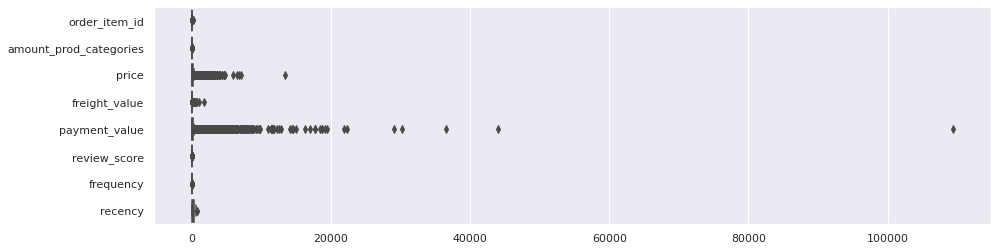

Index(['customer_id', 'order_item_id', 'amount_prod_categories', 'price',
       'freight_value', 'payment_value', 'review_score', 'frequency',
       'recency'],
      dtype='object')
(97916, 9)


In [954]:
#'payment_value'에 굉장히 높은 이상치가 있음
plt.figure(figsize = (15,4))
sns.boxplot(data = df_alldata, orient = "h")
plt.show()
print(df_alldata.columns)
print(df_alldata.shape)

In [955]:
# 이상치 제거를 위한 기준 임의설정
df_alldata1 =df_alldata[df_alldata['payment_value'] > 6000]
print (df_alldata1.shape)

(89, 9)


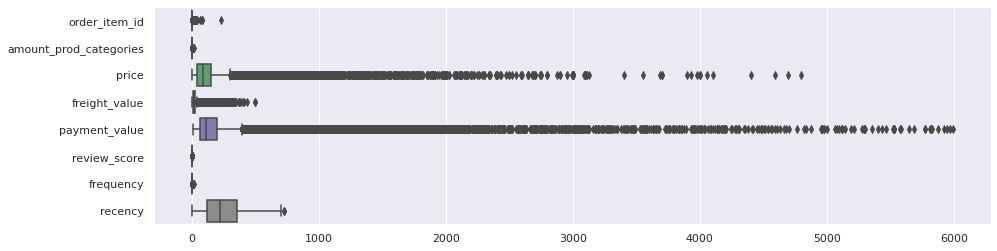

(97827, 9)


In [956]:
df_alldata2 = df_alldata[df_alldata['payment_value'] < 6000]
plt.figure(figsize = (15,4))
sns.boxplot(data =df_alldata2, orient = "h")
plt.show()
print (df_alldata2.shape)

In [957]:
#이상치제거
def detect_outliers(df, features):
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 8 * IQR

        # 이상치 컬럼 리스트
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)        
    return outlier_indices

lof = [ 'price', 'payment_value']
Outliers_to_drop = detect_outliers(df_alldata, lof)

print(len(Outliers_to_drop))

1875


In [958]:
df_alldata = df_alldata.drop(Outliers_to_drop)
print(df_alldata.shape)

(96041, 9)


In [959]:
print(df_alldata.shape)

(96041, 9)


In [960]:
#이상치

In [961]:
#이상치


In [962]:
df_alldata.head()

,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
0,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,1,115
1,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,1,118
2,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,1,541
3,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,1,325
4,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,1,292


## 데이터 탐색

**> 리뷰와 매출의 상관관계**

In [963]:
Image("thevalueofpositivereviews.png",width = 700, height = 400)
# ref. : https://www.qualtrics.com/blog/online-review-stats/

FileNotFoundError: ignored

FileNotFoundError: ignored

<IPython.core.display.Image object>

**> 판매자 평점에 따른 매출**

In [964]:
# 판매자테이블(seller)에서 sellerid 기준 평균평점 과 매출총합 컬럼 추출하기   =======>   best_sellers 테이블생성
best_sellers = df_seller.groupby(['seller_id']).agg({'total_revenue':'sum', 'review_score':'mean'}).reset_index()
best_sellers = best_sellers[['seller_id','review_score','total_revenue']]

#퍙균 평점이 높다고 매출액이 높다고 할 수 없으나
#매출액이 높으면 평균평점이 높음은 확인 할 수 있었음.

In [965]:
# Plotly Express 가져오기
import plotly.express as px

# 판매자 평점에 따른 매출 관계
fig = px.scatter(best_sellers, x="total_revenue", y="review_score", title='Seller rating and revenue')
fig.update_xaxes(tickformat=',')
fig.show()

# 판매자 평점에 따른 매출 관계 2 -- 매출이 0~50,000 사이에 밀집되어 있으므로 해당 구간으로 분포도 재확인
fig = px.scatter(best_sellers, x="total_revenue", y="review_score",title='Seller rating and revenue2 ( total_revenue ≤ 50,000 )')
fig.update_xaxes(range=[-3000,50000])
fig.update_yaxes(range=[0.4,5.4])
fig.update_xaxes(tickformat=',')
fig.show()

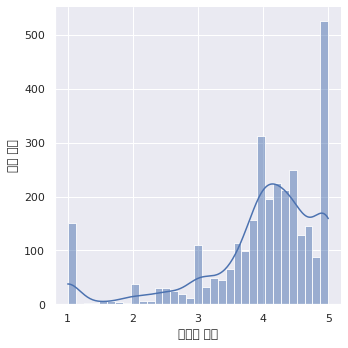

In [966]:
# 판매자 평점 별 누적횟수 -커널덴시티를 그려봤을때 -평균 평점이 5점대가 많아 전반적으로 상품들의 평점이 낮진않다
best_sellers_graph = sns.displot(best_sellers['review_score'],kde=True)
plt.xlabel('판매자 평점')
plt.ylabel('누적 횟수')
plt.show()

<pre> <b>     판매자 평점에 따른 매출
      =========================================================================================================
       
       결론 : Scatter chart에서 매출이 10,000 미만에 밀집되어 있지만, 대체로 매출이 높은데이터는 평점도 높음을 확인할 수 있다.

              (하지만, 정규분포 형태를 띄지 못하므로 데이터의 신뢰성은 떨어진다.)
              
                           
              displot chart에서 평균 평점이 4점 이상에 많이 밀집되어 있지만, 1점에서도 눈에띄는 수치를 확인할 수 있다. 
              
              Scatter chart 에서 평점 1점이 매출이 10,000이 넘어가는 형상을 볼 수 없다.
              
              
              이로 미루어 보았을 때, 판매자 평점은 어느정도 매출에 영향을 준다는 것이 검증되었다.
              
      =========================================================================================================
      

**> 제품 구매 선호도**

> 제품 구매 선호도 - 판매량 높은 Category ( Wordcloud )

In [967]:
df_wordcloud = df_products.merge(product_translations, how = 'left', left_on = 'product_category_name', right_on = 'product_category_name')

In [968]:
df_wordcloud = df_wordcloud.merge(df_items,how = 'left', left_on = 'product_id', right_on = 'product_id')

In [969]:
# df_wordcloud 의 null 값과 shape 확인
print(df_wordcloud.isnull().sum())
print(f'shape: {df_wordcloud.shape}')

product_id                          0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english    1627
order_id                            0
order_item_id                       0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64
shape: (112650, 16)


In [970]:
# wordcloud 를 위해 카테고리 null 값 제거
df_wordcloud = df_wordcloud.dropna(axis=0)
print(df_wordcloud.isnull().sum())
print(f'shape: {df_wordcloud.shape}')

product_id                       0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
order_id                         0
order_item_id                    0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
dtype: int64
shape: (111022, 16)


In [971]:
df_wordcloud.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,e17e4f88e31525f7deef66779844ddce,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,5236307716393b7114b53ee991f36956,1,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,01f66e58769f84129811d43eefd187fb,1,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,143d00a4f2dde4e0364ee1821577adb3,1,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,86cafb8794cb99a9b1b77fc8e48fbbbb,1,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29


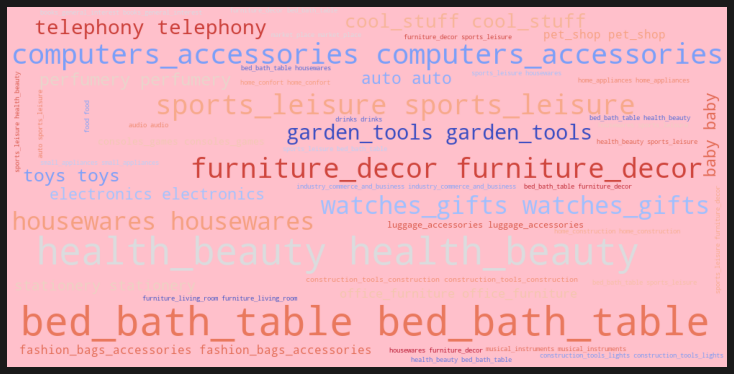

In [972]:
# wordcloud import
from wordcloud import WordCloud

cate = ' '.join(df_wordcloud['product_category_name_english'])
wordcloud = WordCloud(width=1000, height=500,max_words=50, background_color ='pink', colormap='coolwarm')
wordcloud.generate(cate) 
plt.figure(figsize=(10,6),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

> 제품 구매 선호도 - 판매량 높은 Category ( Top 10 )

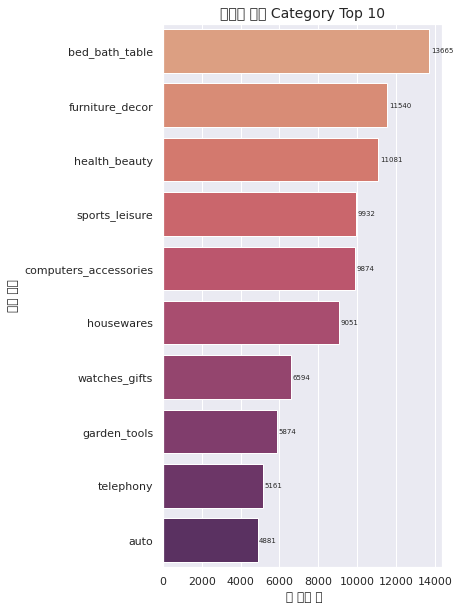

In [973]:
# product_category_name_english 별 총판매량 구하기
cate_cnt = df_wordcloud.groupby(['product_category_name_english']).sum().reset_index() 
# 총 판매량(order_item_id) 내림차순 정렬
cate_cnt = cate_cnt.sort_values(by=['order_item_id'], ascending=False).reset_index()
# 판매량 높은 category Top 10
cate_cnt_10 = cate_cnt.head(10)
## print(cate_cnt[['product_category_name_english','order_item_id']])

# 판매량 높은 category Top 10 barplot
cate_cnt_10_hist = sns.barplot( y=cate_cnt_10["product_category_name_english"], x=cate_cnt_10["order_item_id"], palette="flare" );
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel(' 총 주문 수',fontsize = 12)
plt.ylabel('제품 분류', fontsize = 12)
plt.title("판매량 높은 Category Top 10", fontsize = 14)
for p in cate_cnt_10_hist.patches:
    x, y, width, height = p.get_bbox().bounds
    cate_cnt_10_hist.text(width*1.01, y+height/2, "%d"%(width), va='center',  fontsize = 7)
plt.show()

> 제품 구매 선호도 - 평점 높은 Category ( Top 10 )

In [974]:
df_product_pref = df_wordcloud.merge(df_reviews, how = 'left', left_on = 'order_id', right_on = 'order_id')

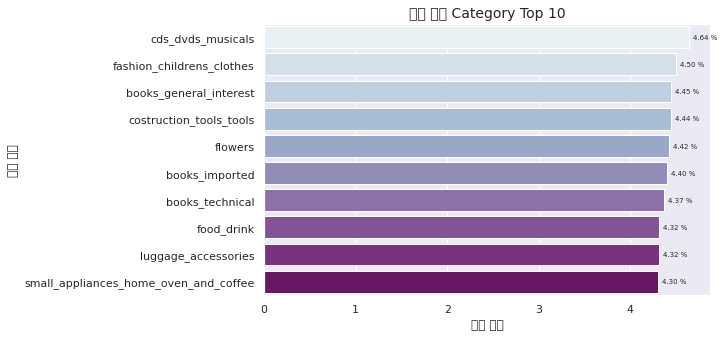

In [975]:
# product_category_name_english 별 평점 구하기
product_rew = df_product_pref.groupby(['product_category_name_english']).mean().reset_index()
# 평점(review_score) 내림차순 정렬
product_rew = product_rew.sort_values(by=['review_score'], ascending=False)
# 평점 높은 category Top 10
product_rew_10 = product_rew.head(10).reset_index()
## print(product_rew_10[['product_category_name_english','review_score']])

# 평점 높은 category Top 10 barplot
product_rew_10_hist = sns.barplot( y=product_rew_10["product_category_name_english"], x=product_rew_10["review_score"], palette="BuPu");
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('평균 평점', fontsize = 12)
plt.ylabel('제품 분류', fontsize = 12)
plt.title("평점 높은 Category Top 10", fontsize = 14)
for p in product_rew_10_hist.patches:
    x, y, width, height = p.get_bbox().bounds
    product_rew_10_hist.text(width*1.01, y+height/2, "%.2f %%"%(width), va='center',  fontsize = 7)
plt.show()

> 제품 구매 선호도 - 매출 높은 Category ( Top 10 )

In [976]:
df_product_pref.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,...,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,...,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39,d71da8fd8c6e3adef26be965f065b8a1,5.0,Vale a pena,Super adooorei o delineador ele é bem preto e ...,2018-04-28 00:00:00,2018-05-04 00:55:02
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,...,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99,19866247db89845ef558ef19a6c26fcd,5.0,NaN,Excelente apontador! Em 3 segundos uma ponta p...,2018-02-17 00:00:00,2018-02-18 23:24:14
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,...,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82,32921b4e09c9a19d61fe46ce04231b84,5.0,NaN,NaN,2018-07-14 00:00:00,2018-07-16 16:20:04
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,...,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54,70949d129965fb1ee32aaccec720a19e,1.0,produto divergente,modelo comprado: travesseiro memoria carinho B...,2018-08-07 00:00:00,2018-08-08 11:53:04
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,...,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29,74c9c7d0bc153bbbc92e4c1597b8ba55,5.0,NaN,NaN,2018-04-17 00:00:00,2018-04-18 04:29:47


In [977]:
df_product_pref = df_product_pref.merge(df_payments, how = 'left', left_on = 'order_id', right_on = 'order_id')
df_product_pref = df_product_pref.groupby(['product_category_name_english']).sum(['payment_value'])
df_product_pref.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_item_id,price,freight_value,review_score,payment_sequential,payment_installments,payment_value
product_category_name_english,,,,,,,,,,,,,,
agro_industry_and_commerce,11251.0,203511.0,563.0,1070574.0,7764.0,6673.0,5706.0,316,83841.95,6966.82,1046.0,494.0,744.0,118730.61
air_conditioning,15429.0,316998.0,706.0,1238106.0,11628.0,6490.0,7902.0,368,55962.38,6848.50,1179.0,307.0,906.0,91170.66
art,10583.0,206890.0,418.0,338874.0,10803.0,1887.0,7986.0,240,24721.97,4191.02,854.0,231.0,490.0,30992.93
arts_and_craftmanship,1123.0,19013.0,89.0,32877.0,742.0,262.0,517.0,26,1814.01,370.13,99.0,24.0,42.0,2326.17
audio,17067.0,297776.0,705.0,462427.0,7627.0,3603.0,5883.0,400,52500.27,5993.89,1448.0,403.0,984.0,60388.62


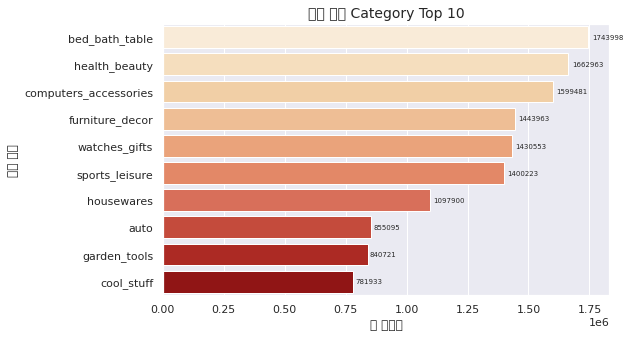

In [978]:
# product_category_name_english 별 총매출 구하기
cate_amt = df_product_pref.groupby(['product_category_name_english']).sum().reset_index() 
# 총 매출(payment_value) 내림차순 정렬
cate_amt = cate_amt.sort_values(by=['payment_value'], ascending=False).reset_index()
# 매출 높은 category Top 10
cate_amt_10 = cate_amt.head(10)
## print(cate_amt[['product_category_name_english','order_item_id']])

# 매출 높은 category Top 10 barplot
cate_amt_10_hist = sns.barplot( y=cate_amt_10["product_category_name_english"], x=cate_amt_10["payment_value"], palette="OrRd" );
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('총 매출액', fontsize = 12)
plt.ylabel('제품 분류', fontsize = 12)
plt.title("매출 높은 Category Top 10", fontsize = 14)
for p in cate_amt_10_hist.patches:
    x, y, width, height = p.get_bbox().bounds
    cate_amt_10_hist.text(width*1.01, y+height/2, "%d"%(width), va='center',  fontsize = 7)
plt.show()

<pre> <b>     판매자 평점에 따른 매출
      =========================================================================================================
       
       결론 : 판매자평점이 높은 상품 카테고리는 cds_dvds_musicals인데, 해당 카테고리의 총 매출액은 상위 10에 들지 않아서예상과 다른 결과가 나왔다. 
      =========================================================================================================
      

**> 지역별 고객현황**

> State 별 고객 수 

In [979]:
df_state= df_customer.merge(df_customers, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

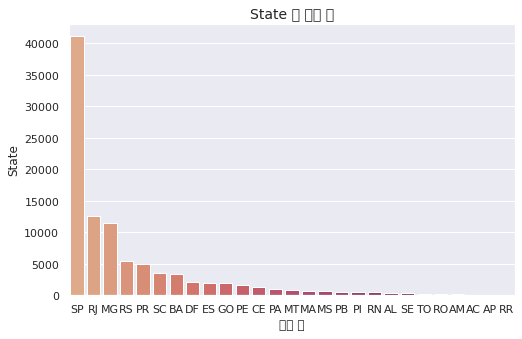

In [980]:
# State 별 고객 수 barplot - 이것만 가지고 각 주가 많은 것을 알 수 없을 것 같음 각 주의 인구수로 나누거나 구매 가능연령대로 나누는 것이 필요할 것 같다.
state_cnt = sns.barplot( y=df_state['customer_state'].value_counts().values, x=df_state['customer_state'].value_counts().index, palette="flare" );
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
plt.xlabel('고객 수', fontsize = 12)
plt.ylabel('State', fontsize = 12)
plt.title("State 별 고객 수", fontsize = 14) 
plt.show()

<pre> <b>     판매자 평점에 따른 매출
      =========================================================================================================
       
       결론 : SP 로 편향되어 있어서 zip_code_prefix 컬럼과 df_geolocation 테이블이 큰 의미가 없다고 판단되어 사용하지 않았다. 
      =========================================================================================================
      

## RFM 분석 

<pre> ●RFM 기반의 고객 세그멘테이션: 고객별로 주문기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션 수행

●데이터를 개별 고객기준의 데이터로 보기 위해 Group by 이용

●CustomerID 기준으로 DataFrame 생성[groupby('customer_unique_id','customer_id')를 적용]

●DataFrame의 groupby()만 이용해서는 여러개의 칼럼에 서로 다른 aggregation 연산(ex) count()나 max()를 한 번에 수행하기 어렵기에 DataFrame을 groupby한 것에 agg()이용

●agg() 에 인자로 대상칼럼들과 aggregation 함수명들을 딕셔너리 형태로 입력허면 칼럼 여러 개의 서로 다른 agggregation 연산을 쉽게 수행가능

●Frequency: 고객별 주문 건수 - CustomerID로 groupby() 해서 orderid의 count() aggregation합으로 구함

●recency : CustomerID로 groupby() 해서 1) ['order_purchase_timestamp'] max()로 고객별 가장 최근 주문 일자를 구함 2) 가장 최근 주문일자에서 주문일자를 뺀 것이 recency 값

●Monetary value : 고객별 주문 금액 CustomerID로 groupby()해서 'payment_value'의 sum() aggregation으로 구함



df_customer 데이터에서 customer_unique_id,customer_id로 그룹화 -> 'order_purchase_timestamp'의 max()로 고객별 가장 최근 주문일 구함

<pre>● recency를 구했으니 ['order_purchase_timestamp'] 드랍 (불필요하기 때문)
● order_id 의 columns명 frequency로 변경

In [981]:
df_customer.head()

,customer_unique_id,customer_id,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,order_purchase_timestamp,order_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,1,1,129.90,12.00,141.90,5.0,2018-05-10 10:56:27,1,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,1,1,18.90,8.29,27.19,4.0,2018-05-07 11:11:27,1,118
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,1,1,69.00,17.22,86.22,3.0,2017-03-10 21:05:03,1,541
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,1,1,25.99,17.63,43.62,4.0,2017-10-12 20:29:41,1,325
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,1,1,180.00,16.89,196.89,5.0,2017-11-14 19:45:42,1,292


In [982]:
df_RFM= df_orders.merge(df_payments, how = 'left', left_on ='order_id', right_on = 'order_id')
print(df_RFM.columns) 

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')


●거래 데이터 정보 생성 (고객ID, FRM)

In [983]:
transaction_data = df_alldata[['customer_id','frequency','recency','payment_value']]
print(transaction_data.shape)
transaction_data.head()

(96041, 4)


,customer_id,frequency,recency,payment_value
0,fadbb3709178fc513abc1b2670aa1ad2,1,115,141.90
1,4cb282e167ae9234755102258dd52ee8,1,118,27.19
2,9b3932a6253894a02c1df9d19004239f,1,541,86.22
3,914991f0c02ef0843c0e7010c819d642,1,325,43.62
4,47227568b10f5f58a524a75507e6992c,1,292,196.89


● describe로 살펴보면 ,
-Recency - 평균과 중위 50% 값의 차이가 크지 않지만,
max값이 728로 75%인(3/4)분위인 355보다 훨씬 크고 상위 몇개의 큰 값으로 인해 왜곡된 것으로 생각됨.

-Frequency - 평균 1.14~ 인데 분위 값들이 모두 1로 특정 범위에 값이 몰려 있어 왜곡정도가 심함.

-monetary_value - 평균은 206인데 75%(3/4분위)값에 가까움
이는 max값을 포함한 상위 몇개의 큰값으로 인해 발생한 현상이라고 판단.




In [984]:
df_RFM = transaction_data.rename(columns={"payment_value": "monetary_value"})
df_RFM = df_RFM.reset_index()


In [985]:
df_RFM[['recency','frequency','monetary_value']].describe()

,recency,frequency,monetary_value
count,96041.000000,96041.000000,96041.000000
mean,244.644714,1.117606,162.255422
std,153.386890,0.407942,168.049092
min,0.000000,1.000000,9.590000
25%,121.000000,1.000000,62.210000
50%,226.000000,1.000000,107.780000
75%,354.000000,1.000000,188.980000
max,728.000000,8.000000,1262.920000


frequency, monetary의 경우 특정 범위에 값이 몰려 있어 왜곡 정도가 매우 심함

(array([57998., 23179.,  6899.,  3053.,  1834.,  1262.,   879.,   528.,
          258.,   151.]),
 array([   9.59 ,  134.923,  260.256,  385.589,  510.922,  636.255,
         761.588,  886.921, 1012.254, 1137.587, 1262.92 ]),
 <a list of 10 Patch objects>)

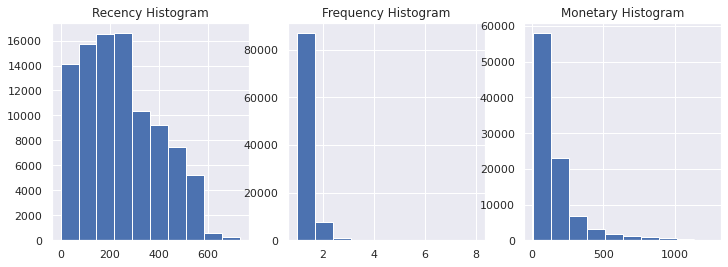

In [986]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(df_RFM['recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(df_RFM['frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(df_RFM['monetary_value'])

In [987]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [988]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

<pre>
●왜곡정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행
●1차 시도 -> StandardScaler로 평균과 표준편차를 재조정 한 뒤에 K-평균을 수행


In [989]:
####################################오래걸림 ####################################
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , silhouette_samples

X_features = df_RFM[['recency','frequency','monetary_value']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
df_RFM['cluster_label'] = labels
print('실루엣 스코어는 : {0:3f}'.format(silhouette_score(X_features_scaled, labels)))

KeyboardInterrupt: ignored

In [ ]:
####################################오래걸림 ####################################
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

<pre>
●군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 0.478로 안정적인 수치를 나타냄.

●하지만, 각 군집별 실루엣계수를 살펴보면 
군집이 2개인 경우 - 0번 군집의 데이터 건수가 매우 작음
 ""    3개인경우  - 1번 건수가 작음
       4개인경우  - 2,3번 작음
       5개인경우  - 2,3,4 작음
●이 데이터 건수가 작은 군집은 개수가 작고 실루엣 계수도 상대적으로 작을 뿐만 아니라 데이터도 광범위하게 퍼져있음.

●데이터세트의 왜곡정도를 낮추기 위해 데이터 값에 로그(Log를 적용)후 결과 비교

<pre>
●왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법 - 로그변환
●변환후 - 평균 알고리즘 적용

In [ ]:
####################################오래걸림 ####################################
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , silhouette_samples

df_RFM['Recency_log'] = np.log1p(df_RFM['recency'])
df_RFM['Frequency_log'] = np.log1p(df_RFM['frequency'])
df_RFM['Monetary_log'] = np.log1p(df_RFM['monetary_value'])

X_features_scaled = df_RFM[['Recency_log','Frequency_log','Monetary_log']]

kmeans= KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
df_RFM['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

In [ ]:
####################################오래걸림 ####################################
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

<pre>● 실루엣스코어는 0.347로 로그변환 이전인 0.479보다 개선되었고 군집화 구성을 보면
StandardScaler()보다 더 균일하게 군집화가 구성됨
-> 왜곡된 데이터의 경우 로그변환으로 데이터를 변환후 군집화를 수행하면 더 나은 결과 도출

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(df_RFM['Recency_log'])

ax2.set_title('Frequency Histogram')
ax2.hist(df_RFM['Frequency_log'])

ax3.set_title('Monetary Histogram')
ax3.hist(df_RFM['Monetary_log'])

In [990]:
df_RFM = df_RFM[df_RFM['frequency']>0]  # 결제 취소건은 포함 안 하므로
df_RFM.describe()

,index,frequency,recency,monetary_value,cluster_label
count,96041.000000,96041.000000,96041.000000,96041.000000,96041.000000
mean,48960.099041,1.117606,244.644714,162.255422,1.682229
std,28260.310545,0.407942,153.386890,168.049092,1.396621
min,0.000000,1.000000,0.000000,9.590000,0.000000
25%,24492.000000,1.000000,121.000000,62.210000,0.000000
50%,48959.000000,1.000000,226.000000,107.780000,3.000000
75%,73433.000000,1.000000,354.000000,188.980000,3.000000
max,97915.000000,8.000000,728.000000,1262.920000,3.000000


In [991]:
quintiles = df_RFM[['recency','frequency','monetary_value']].quantile([.2,.4,.6,.8]).to_dict()
quintiles

{'recency': {0.2: 100.0, 0.4: 184.0, 0.6: 275.0, 0.8: 390.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary_value': {0.2: 54.49, 0.4: 86.73, 0.6: 133.76, 0.8: 217.9}}

Recency	고객이 최근에 구입을 했는가?			=> 숫자가 작을수록 높은점수	
Frequency	고객이 얼마나 빈번하게 상품을 구입했는가?			=> 숫자가 높을수록 높은점수	
Monetary	고객이 구입했던 총 금액은 얼마인가?			=> 숫자가 높을수록 높은점수


=========== > 점수 부여기준이 다르므로 함수 두개 생성 		:  	r_score 와 fm_score



In [992]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x,c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [993]:
df_RFM['R']= df_RFM['recency'].apply(lambda x: r_score(x))
df_RFM['F']= df_RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df_RFM['M'] = df_RFM['monetary_value'].apply(lambda x: fm_score(x, 'monetary_value'))

In [994]:
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value,cluster_label,R,F,M,RFM Score
0,0,fadbb3709178fc513abc1b2670aa1ad2,1,115,141.90,3,4,1,4,414
1,1,4cb282e167ae9234755102258dd52ee8,1,118,27.19,3,4,1,1,411
2,2,9b3932a6253894a02c1df9d19004239f,1,541,86.22,0,1,1,2,112
3,3,914991f0c02ef0843c0e7010c819d642,1,325,43.62,0,2,1,1,211
4,4,47227568b10f5f58a524a75507e6992c,1,292,196.89,0,2,1,4,214


In [995]:
Image('/content/img/RFM_score.png',width = 700, height=200)

FileNotFoundError: ignored

FileNotFoundError: ignored

<IPython.core.display.Image object>

In [996]:
segt_map = {
     r'[1-2][1-2]': '최근구매없음/구매횟수적음',
     r'[1-2][3-4]': '최근구매없음/구매횟수보통',
     r'[1-2]5': '최근구매없음/구매횟수많음',
     r'3[1-2]': '비교적최근구매함/구매횟수적음',
     r'33': '비교적최근구매함/구매횟수보통',
     r'[3-4][4-5]': '최근구매함/구매횟수많음',
     r'41': '최근구매함/구매횟수적음',
     r'51': '방금전구매함/구매횟수적음',
     r'[4-5][2-3]': '방금전구매함/구매횟수보통/프로모션대상',
      r'5[4-5]': '방금전구매함/구매횟수많음'
     }
df_RFM['Segment'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex= True)
df_RFM.head()

,index,customer_id,frequency,recency,monetary_value,cluster_label,R,F,M,RFM Score,Segment
0,0,fadbb3709178fc513abc1b2670aa1ad2,1,115,141.90,3,4,1,4,414,최근구매함/구매횟수적음
1,1,4cb282e167ae9234755102258dd52ee8,1,118,27.19,3,4,1,1,411,최근구매함/구매횟수적음
2,2,9b3932a6253894a02c1df9d19004239f,1,541,86.22,0,1,1,2,112,최근구매없음/구매횟수적음
3,3,914991f0c02ef0843c0e7010c819d642,1,325,43.62,0,2,1,1,211,최근구매없음/구매횟수적음
4,4,47227568b10f5f58a524a75507e6992c,1,292,196.89,0,2,1,4,214,최근구매없음/구매횟수적음


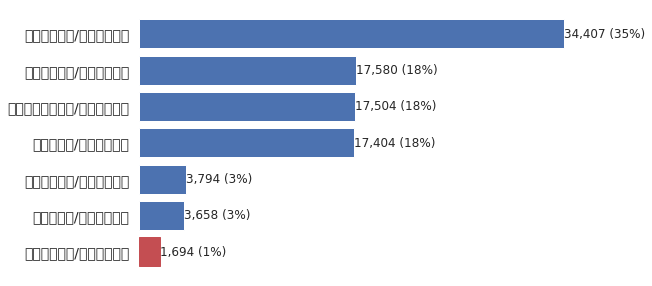

In [997]:
segments_counts = df_RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='b')

ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)

ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['방금전구매함/구매횟수보통/프로모션대상', '방금전구매함/구매횟수많음']:
            bar.set_color('r')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.show()

In [998]:
df_RFM['frequency'].value_counts()


1    86895
2     7623
3     1073
4      328
5       70
6       51
8        1
Name: frequency, dtype: int64

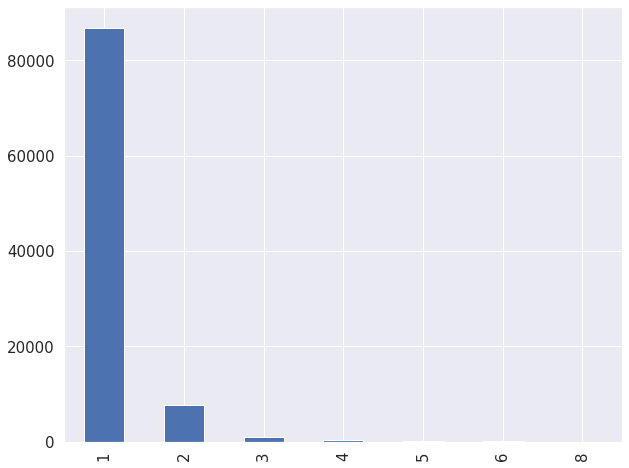

In [999]:
freq_hist = pd.value_counts(df_RFM['frequency'].values, sort=True)
freq_hist.plot.bar()
freq_hist.plot.bar(grid=True, figsize=(10,8), fontsize=15) 

RFM 분석을 해본 결과, 데이터가 생각보다 디테일하지 않음.
전체 총 구매 횟수 중에 5만 명이 넘는 고객군이 고작 1번의 구매 횟수라는 충격적인 결과를 도출했으며, 최대 15번 구매를 한 고객군 또한 고작 1명뿐이었다. RFM은 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법이다.
1번만 구매한 5만 명의 고객군을 등급별로 나누는 게 의미가 있을까라는 결론

 RFM 분석을 해 본 결과, 
 이상적인 데이터 결과는 recency가 적고(r_score 크고), frquency가 높은 고객이 많은 그래프지만 frequency가

## Unsupervised Segmentation

In [1000]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


### K-Means Clustering

#### Feature Selection

유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다 - customer_id

Target Feature 가 포함되어 있으면 함께 제거

In [1001]:
num_feat = df_alldata.select_dtypes('number').columns.values
df_alldata_num = df_alldata[num_feat].copy()
print(df_alldata_num.nunique().sort_values())

frequency                     7
amount_prod_categories        8
order_item_id                 9
review_score                 11
recency                     614
price                      6846
freight_value              7196
payment_value             28338
dtype: int64


In [1002]:
df_alldata_num = df_alldata_num.drop(['customer_id '], axis=1, errors='ignore')

In [1003]:
df_alldata_num.head()

,order_item_id,amount_prod_categories,price,freight_value,payment_value,review_score,frequency,recency
0,1,1,129.90,12.00,141.90,5.0,1,115
1,1,1,18.90,8.29,27.19,4.0,1,118
2,1,1,69.00,17.22,86.22,3.0,1,541
3,1,1,25.99,17.63,43.62,4.0,1,325
4,1,1,180.00,16.89,196.89,5.0,1,292


## 상관계수 구하기

In [1004]:
num_feat = df_alldata.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat,2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df_alldata[comb[0]],df_alldata[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [1005]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.95]
high_corr_num

array([['order_item_id', 'frequency']], dtype='<U22')

In [1006]:
#order_item_id 와 frequency 의 상관계수가 0.96 으로 다중 공선성을 띈다. 두 피처 중 다른 피처와 상관관계를 고려하여 조금 더 의미 있는 'frequency' 를 남겨두고 'order_item_id' 를 제거한다.
df_alldata_reduced = df_alldata_num.drop(['order_item_id'], axis=1, errors='ignore')

In [1007]:
#price와 freight_value 를 합친 값이 결국 payment_value 이므로, 두 피처는 제거한다.
df_alldata_reduced = df_alldata_reduced.drop(['price','freight_value'],axis=1, errors='ignore')

In [1008]:
df_alldata_reduced.head()

,amount_prod_categories,payment_value,review_score,frequency,recency
0,1,141.90,5.0,1,115
1,1,27.19,4.0,1,118
2,1,86.22,3.0,1,541
3,1,43.62,4.0,1,325
4,1,196.89,5.0,1,292


In [1009]:
import plotly.offline as py
import plotly.graph_objs as go
# plotly 안 보이는 문제 해결

import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=df_alldata_reduced.astype(float).corr().values, # 피어슨 상관계수
        x=df_alldata_reduced.columns.values,
        y=df_alldata_reduced.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')


Feature Skewness 확인 # 왜 사용했는지 확인 필요 - 왜도와 첨도를 확인하여 정규분포를 확인 - 특정 범위에 값이 몰려 있어 이상치로 볼 수 있는 데이터가 다수 포함(higly skewed) 
-> Scaling 진행

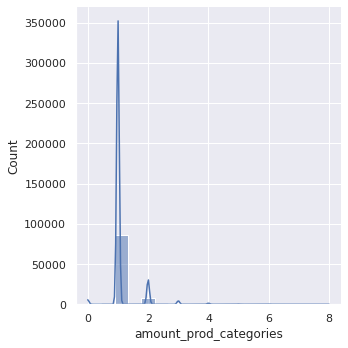

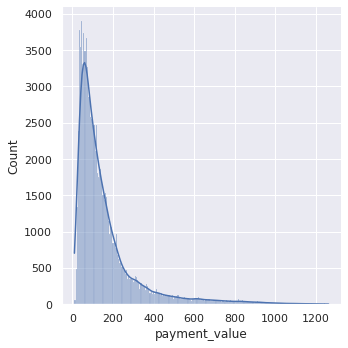

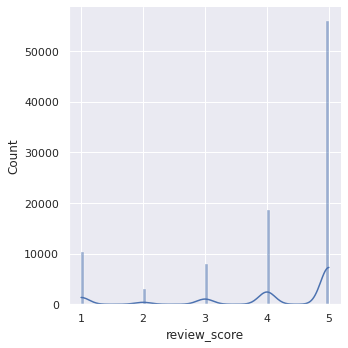

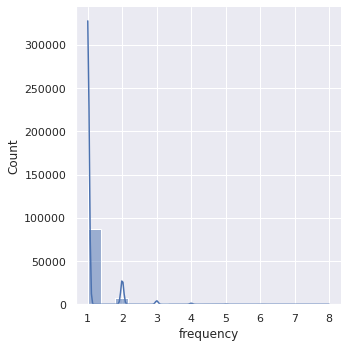

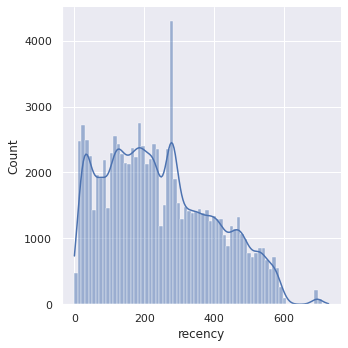

In [1010]:
col_alldata_reduced = df_alldata_reduced.columns.values
for i in range(0, len(col_alldata_reduced)):
    sns.displot(df_alldata_num[col_alldata_reduced[i]], kde=True) #kde : kernel density

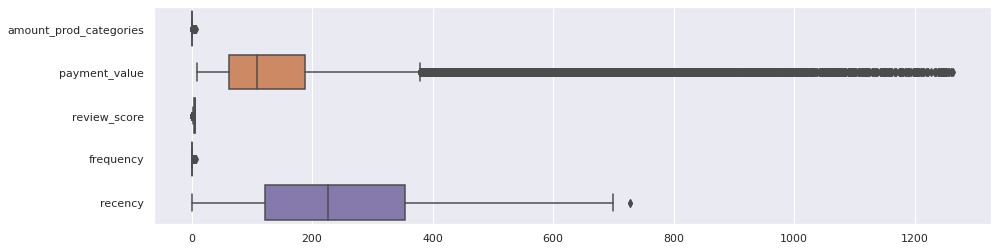

In [1011]:
#박스플롯을 그려 이상치를 확인 
plt.figure(figsize = (15,4))
sns.boxplot(data =df_alldata_reduced, orient = "h")
plt.show()

In [1012]:
df_alldata_reduced.head()

,amount_prod_categories,payment_value,review_score,frequency,recency
0,1,141.90,5.0,1,115
1,1,27.19,4.0,1,118
2,1,86.22,3.0,1,541
3,1,43.62,4.0,1,325
4,1,196.89,5.0,1,292


#### Scaling

In [1013]:
# 정규화 진행
scaler = StandardScaler()
scaler.fit(df_alldata_reduced)
df_alldata_reduced_scaled = scaler.transform(df_alldata_reduced)

In [1014]:
scaled_dataframe = pd.DataFrame(df_alldata_reduced_scaled, columns= df_alldata_reduced.columns)

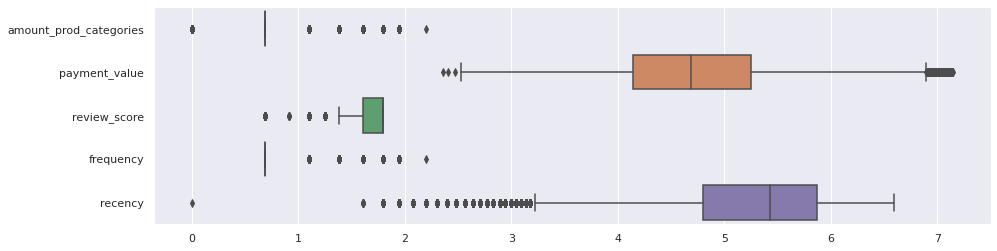

In [1015]:
#1차시도 log scaling
plt.figure(figsize = (15,4))
sns.boxplot(data =df_alldata_reduced_log, orient = "h")
plt.show()

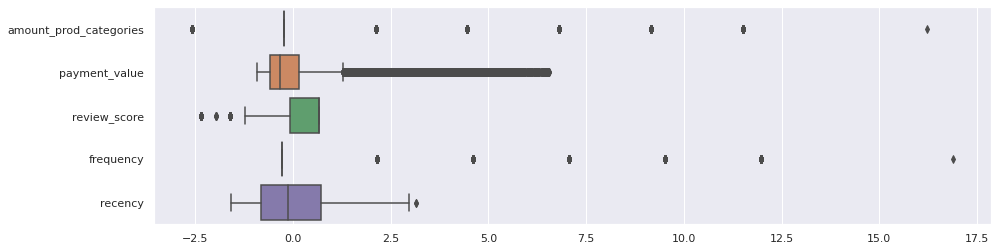

In [1016]:
#2차시도 Standard scaling
plt.figure(figsize = (15,4))
sns.boxplot(data =scaled_dataframe, orient = "h")
plt.show()

In [1017]:
scaled_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96041 entries, 0 to 96040
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   amount_prod_categories  96041 non-null  float64
 1   payment_value           96041 non-null  float64
 2   review_score            96041 non-null  float64
 3   frequency               96041 non-null  float64
 4   recency                 96041 non-null  float64
dtypes: float64(5)
memory usage: 3.7 MB


## **군집화**

몇 개로 군집화를 해야할까?
위의 데이터를 몇 개의 군집화로 나누는것이 가장 올바른 군집화인지 살펴보자


`KMeans(n_cluster = k)`

- k개의 군집화를 하겠다는 객체 생성

`Kmeans.fit()`

- 학습시키기

`KMeans.inertia_`

- 학습된 KMeans의 응집도를 확인
- 응집도란 각 데이터로부터 자신이 속한 군집의 중심까지의 거리를 의미
- 즉, 낮을수록 군집화가 더 잘되어있음.

`KMeans.predict(data)`

- 학습된 데이터를 바탕으로 데이터를 변환시켜줌

In [1018]:
#5개의 feature가 있음.
scaled_dataframe.head()
scaled_dataframe.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96041 entries, 0 to 96040
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   amount_prod_categories  96041 non-null  float64
 1   payment_value           96041 non-null  float64
 2   review_score            96041 non-null  float64
 3   frequency               96041 non-null  float64
 4   recency                 96041 non-null  float64
dtypes: float64(5)
memory usage: 3.7 MB


Why Combine PCA and K-means Clustering?
By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.

In [1020]:
# 1.pca 클래스의 (instance)를 생성
# 2.data를 pca변수에 학습
pca=PCA()
pca.fit(scaled_dataframe)
# 이제,pca는 데이터의 feature 5개만큼 주성분을 생성
# 이러한 주성분은 중요도에 따라 정렬 , 중요도 : 데이터의 pca분산이 주성분에 의해 설명되는 정도
#

PCA()

In [1021]:
#explained_variance_ratio_을 확인
#-5개의 구성요소(data에 선형변환을 적용하여 5개의 새로운 변수 생성)
#-5개중 일부는 분산의 많은 부분을 설명 ,다른 것들은 그렇지 못함.
#-5개의 주성분이 데이터의 변동성을 100%설명, 이 설명분산비율을 모두 합하면 1
pca.explained_variance_ratio_

array([0.46972068, 0.20222347, 0.1938821 , 0.12331839, 0.01085535])

Text(0, 0.5, 'Culmulative Explained Variance')

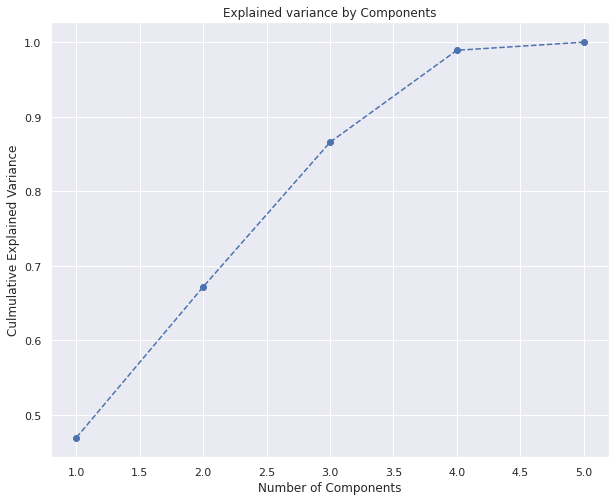

In [1022]:
# 유지할 주성분의 수를 결정하기 위해 누적설명분산율 시각화 (cumsum()이용)
# 아래 그래프는 포함시킬 성분의 수에 따른 분산의 비율을 나타냄
# 피쳐의 수를 줄이며 rawdata의 80%를 설명 할 수 있는 3을 유지할 주성분으로 설정
plt.figure(figsize= (10,8))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o',linestyle = '--')
plt.title('Explained variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Culmulative Explained Variance')

In [1023]:
pca=PCA(n_components = 3)
pca.fit(scaled_dataframe)

PCA(n_components=3)

In [1024]:
# n_components =3 으로 유지시킨 결과를 scores_pca에 저장 (k-means clustering을 수행하기 위함) 
scores_pca = pca.transform(scaled_dataframe)

In [1025]:
# cluster의 수를 결정하기 위해 Elbow method 이용
#군집갯수에 따른 군집별 데이터 갯수(WCSS)로 그래프를 그려 변곡점의 데이터 사용
# 군집의 개수가 4개일때부터 기울기가 달라지는 것으로 판단 ->군집수 4로 지정


wcss = []
for i in range(1,20):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
  kmeans_pca.fit(scores_pca)
  wcss.append(kmeans_pca.inertia_)

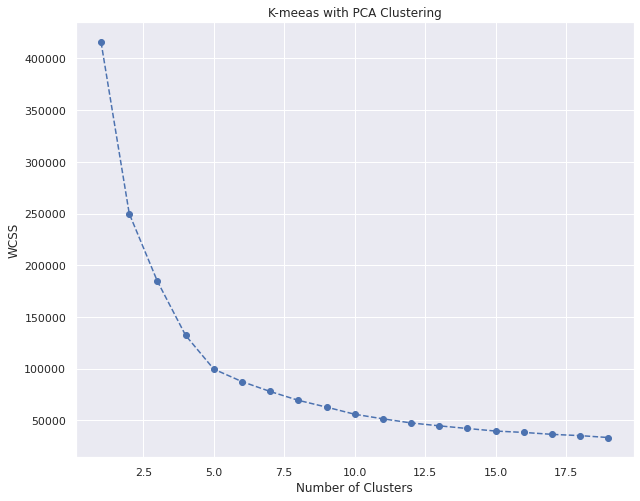

In [1026]:
plt.figure(figsize= (10,8))
plt.plot(range(1,20), wcss,marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-meeas with PCA Clustering')
plt.show()


In [1027]:
# 위에서 구한 주성분 값을 KMeans 모델에 학습

kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

# 기존데이터와 pca 점수데이터 프레임을 결합하여 새로운 데이터 프레임 생성
df_alldata_reduced_kmeans = pd.concat([df_alldata_reduced.reset_index(drop=True),pd.DataFrame(scores_pca)], axis=1)
df_alldata_reduced_kmeans.head()


,amount_prod_categories,payment_value,review_score,frequency,recency,0,1,2
0,1,141.90,5.0,1,115,-0.464735,-1.042654,0.095853
1,1,27.19,4.0,1,118,-0.694950,-0.620449,-0.562561
2,1,86.22,3.0,1,541,-0.434631,2.120492,0.223192
3,1,43.62,4.0,1,325,-0.646805,0.534339,0.134406
4,1,196.89,5.0,1,292,-0.309015,-0.062315,0.700568


In [1028]:
df_alldata_reduced_kmeans.columns.values[-3:]=   ['Components 1','Components 2','Components 3']
df_alldata_reduced_kmeans['cluster'] = kmeans_pca.labels_

In [1029]:
df_alldata_reduced_kmeans.head()

,amount_prod_categories,payment_value,review_score,frequency,recency,Components 1,Components 2,Components 3,cluster
0,1,141.90,5.0,1,115,-0.464735,-1.042654,0.095853,0
1,1,27.19,4.0,1,118,-0.694950,-0.620449,-0.562561,0
2,1,86.22,3.0,1,541,-0.434631,2.120492,0.223192,3
3,1,43.62,4.0,1,325,-0.646805,0.534339,0.134406,3
4,1,196.89,5.0,1,292,-0.309015,-0.062315,0.700568,3


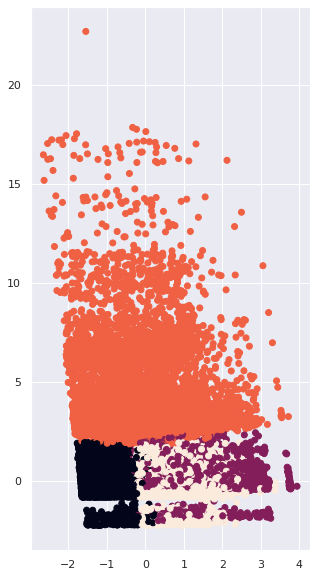

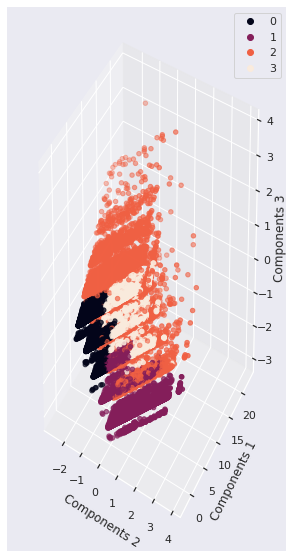

<Figure size 1440x3600 with 0 Axes>

In [1033]:
s = plt.scatter(df_alldata_reduced_kmeans['Components 2'], df_alldata_reduced_kmeans['Components 1'], c=df_alldata_reduced_kmeans['cluster'])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_alldata_reduced_kmeans['Components 2'], df_alldata_reduced_kmeans['Components 1'], df_alldata_reduced_kmeans['Components 3'], c=df_alldata_reduced_kmeans['cluster'])
ax.set_xlabel('Components 2')
ax.set_ylabel('Components 1')
ax.set_zlabel('Components 3')
plt.legend(s.legend_elements()[0], list(set(df_alldata_reduced_kmeans['cluster'])))
plt.figure(figsize= (20,50))
plt.show()

In [ ]:
#레이블에 cluster 이름(0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4') 맵핑
df_alldata_reduced_kmeans['cluster'] = df_alldata_reduced_kmeans['cluster'].map({0:'Cluster1',1:'Cluster2',2:'Cluster3',3:'Cluster4'})

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x= df_alldata_reduced_kmeans['Components 2']
y= df_alldata_reduced_kmeans['Components 1']
z= df_alldata_reduced_kmeans['Components 3']

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
sc = ax.scatter(x,y,z, alpha=0.4, cmap='rainbow', s=20)

plt.legend(*sc.legend_elements())
plt.colorbar(sc)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = df_alldata_reduced_kmeans['Components 2']
    ys = df_alldata_reduced_kmeans['Components 1']
    zs = df_alldata_reduced_kmeans['Components 3']
    ax.scatter(xs, ys, zs, marker=m, cmap= ['g','r','c','m'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
import sys

In [ ]:
import pandas as pd

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 군집화

In [ ]:
# 라이브러리 불러오기
from sklearn.cluster import KMeans

In [ ]:
x = [] # k가 몇개인지
y = [] # 응집도가 몇인지

for k in range(1,30) :
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_pca)
    
    x.append(k)
    y.append(kmeans.inertia_)

In [ ]:
# 그래프 그리기
plt.plot(x, y)
plt.xticks(range(0,30,2), range(0,30,2))
plt.show()

방법 2 ) KElbowVisualizer 라이브러리 이용

In [ ]:
####################################오래걸림 ####################################
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_pca)


## ELBOW POINT 4 지정 후 클러스터링 시작

In [ ]:
kmeans = KMeans(n_clusters = 4)

In [ ]:
kmeans.fit(df_pca)

In [ ]:
df_pca['labels'] = kmeans.predict(df_pca)

In [ ]:
df_pca.head()

In [ ]:
sns.scatterplot(x = 'pc1', y='pc2', hue = 'labels', data= df_pca)

#### Hyperparameters Optimization 

##### Elbow Method

결론: Elbow Method -> K=4

#### 시각화

PCA

In [ ]:
pca_feat = PCA(n_components=2)
X_PCA = pca_feat.fit_transform(df_clustered)
print(pca_feat.explained_variance_ratio_)

features = range(pca_feat.n_components_)  

# 원본 데이터 df_reduced가 scaling한 df_reduced_scaled 보다 결과가 좋게 나온다. ---> why??
# df_reduced 를 사용할지, df_reduced_scaled를 사용해서 PCA할지 



In [ ]:
df_PCA = pd.DataFrame.from_records(X_PCA)
clust_series = pd.Series(clust)
clust_series.head()

In [ ]:
df_PCA = df_PCA.assign(cluster = clust_series)
df_PCA.columns

In [ ]:
df_PCA = df_PCA.rename(columns={0: 'PCA_1', 1: 'PCA_2'})
df_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Test values"}, inplace=True)
df_PCA.head()

In [ ]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.title('PCA 를 이용한 K-Means Cluster Plot', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

T-SNE

In [ ]:
print(kmeans.labels_)


In [ ]:
df_PCA.head() 

In [ ]:
# df_reduced['cluster']=kmeans.labels_


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df_reduced)

df_reduced['pca_x'] = pca_transformed[:,0]
df_reduced['pca_y'] = pca_transformed[:,1]



In [ ]:
df_reduced.head()


In [ ]:
pca_feat = PCA(n_components=2)
X_PCA = pca_feat.fit_transform(df_clustered)
print(pca_feat.explained_variance_ratio_)

features = range(pca_feat.n_components_)

In [ ]:
df_PCA = pd.DataFrame.from_records(X_PCA)
clust_series = pd.Series(clust)
clust_series.head()

In [ ]:
df_PCA = df_PCA.assign(cluster = clust_series)
df_PCA.columns

In [ ]:
df_PCA = df_PCA.rename(columns={0: 'PCA_1', 1: 'PCA_2'})
df_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_PCA.head()

In [ ]:
df_PCA = df_PCA.dropna()
print(df_PCA.columns, df_PCA.shape)

In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = df_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= orderhue,markers='o'
, scatter_kws={"s":200, "alpha":0.6}, palette="tab10")

plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.title('PCA 를 이용한 K-Means Cluster Plot', fontsize = 20)
plt.legend(fontsize = 14)
plt.xlim([-200, 1000])      # X축의 범위: [xmin, xmax]
plt.ylim([-200, 500])     # Y축의 범위: [ymin, ymax]

plt.show()

In [ ]:
df_clustered_labeled = df_clustered.assign(cluster = clust_series)
df_clustered_labeled.head()

In [ ]:
df_clustered_labeled.cluster.unique()

In [ ]:
df_train.head()

In [ ]:
df_reduced.head()

In [ ]:
columnsvector = df_reduced.columns
print(columnsvector)
df_train_labeled = df_train
df_train_labeled.columns = columnsvector

In [ ]:
df_train_labeled = df_train_labeled.assign(cluster = clusts_train)
df_train_labeled["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"}, inplace=True)
df_train_labeled.head()

In [ ]:
x1 = df_train_labeled["cluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]

order = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

In [ ]:
plt.figure(figsize=(16,16))

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x1, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x1, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x1, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x1, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x1, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()



# 클러스터1 이 최근에도 구매한 회원들, 3이 최근 구매내역 없는 회원들

#payment - 클러스터 1,3 은 작은 그룹, 2는 큰 그룹


### Local Linear Embedding

### T-SNE

 < t-SNE : t-Distributed Stochastic Neighbor Embedding > 
t-SNE는 매니폴드 학습의 하나로 복잡한 데이터의 시각화가 목적이다. 높은 차원의 데이터를 2차원 또는 3차원으로 축소시켜 시각화 한다.
t-SNE를 사용하면 높은 차원 공간에서 비슷한 데이터 구조는 낮은 차원 공간에서 가깝게 대응하며, 비슷하지 않은 데이터 구조는 멀리 떨어져 대응된다.

작용원리 : 각 데이터 포인트를 2차원에 무작위로 표현한 후 원본 특성 공간에서 가까운 포인트는 가깝게, 멀리 떨어진 포인트는 멀어지게 만든다.
          t-SNE는 가까이 있는 포인트에 더 많은 비중을 둔다. 따라서 이웃 데이터 포인트에 대한 정보를 보존하려 한다.

* References
  다른 거리를 이용한 t-SNE ( 지승영 )   https://url.kr/gs4ib8
  API :https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

> PCA 와 t-SNE 의 차이

PCA 는 선형변환을 이용하기 때문에 비선형 특성을 가진 데이터에 대해서는 데이터의 특성을 잘 추출하지 못하는 한계가 있다.</br>
t-SNE는 비선형적인 방법의 차원 축소 방법이며, 고차원의 데이터 셋을 시각화하는 것에 성능이 좋다.

In [ ]:
Image("./dataset/pca_tsne.png",width = 500, height = 200)
# ref. : https://gaussian37.github.io/ml-concept-t_sne/

In [ ]:
############################## Skitlearn Tsne API ##############################
# class sklearn.manifold.TSNE
# (n_components=2  ---------------- 차원 축소 결과 임베딩되는 차원 (default=2) (필수)
#  , perplexity=30.0  ------------- 다른 manifold learning의 nearest neighbors 갯수에 사용되는 값 (5 ~ 50 사이의 값 조정)
#  , early_exaggeration=12.0
#  , learning_rate='warn' -------- 학습을 할 때 사용하는 learning rate (일반적으로 10 ~ 1000 사이의 값)
#  , n_iter=1000  --------------- 최적화를 위한 최대 반복 횟수 (최소 250은 넣어주는걸 권고)
#  , n_iter_without_progress=300  ----------- 성능 개선 없이 학습이 지속되면 학습을 중지하는 옵션 (50 배수 단위로 카운트 됨)
#  , min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='warn', verbose=0, random_state=None
#  , method='barnes_hut', angle=0.5, n_jobs=None, square_distances='deprecated')

In [ ]:
# t-SNE 설정하기
tsne = TSNE(n_components=2, perplexity=31, random_state=2020)

##############################오래걸립뉘다 ##############################
# df_clustered (클러스터링 값) tsne로 fit_transform
X_concat = df_clustered.values
X_TSNE = tsne.fit_transform(X_concat)

In [ ]:
df_TSNE = pd.DataFrame.from_records(X_TSNE)
print(df_TSNE.shape)
df_TSNE.head()


In [ ]:
clust_series = pd.Series(clust)
df_TSNE = df_TSNE.assign(cluster = clust_series)

print(df_TSNE.columns, df_TSNE.shape)
df_TSNE = df_TSNE.rename(columns={0: 'TSNE_1', 1: 'TSNE_2'})
df_TSNE["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 40: "Test values"}, inplace=True)
df_TSNE.head()

In [ ]:
df_TSNE["cluster"].value_counts()


In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'TSNE_1', y = 'TSNE_2', data = df_TSNE, fit_reg = False, legend = True, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.15} )
plt.xlabel('TSNE component 1', fontsize = 14)
plt.ylabel('TSNE component 2', fontsize = 14)
plt.rc('font', family='NanumBarunGothic')
plt.title('T-SNE 를 이용한 K-Means Cluster Plot', fontsize = 20)
plt.show()


In [ ]:
 강사님 지금까지 저희 열심히 했는데 위에 코드 결과가 늦게 나올 것 같아서 조금만 쉬고 있겠습니다!! (혹시나 소회의실 오실까봐요~)

●DBSCAN - 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어서 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 군집화를 잘 수행할 수 있음
( K평균, 평균 이동, GMM방식등으로 수행하기 어려운 기하학적 데이터에 이 방식으로 효과적인 군집화 수행 가능)

In [ ]:
eps_to_test = [0.01, 0.02]
min_samples_to_test = [10, 20, 75]
print("EPS VALUES:", eps_to_test)
print("MIN_SAMPLES:", min_samples_to_test)

In [ ]:
def get_metrics(eps, min_samples, dataset, iter_):
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)

    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [ ]:
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))),
    columns = min_samples_to_test, 
    index = eps_to_test
)

results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))),
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [ ]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        noise_metric, cluster_metric = get_metrics(eps, min_samples, X_train, iter_)
        
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

In [ ]:
eps = 0.01
min_samples_to_test = 11

dbscan_model = DBSCAN( eps = eps, min_samples = min_samples_to_test)
DBclusts_train = dbscan_model.fit(X_train)


In [ ]:
noise_metric, cluster_metric = get_metrics(eps, min_samples_to_test, X_train, 1)

In [ ]:
DBclust = np.concatenate((DBclusts_train.labels_, clusts_test), axis=None)
print(clusts_test.shape ,DBclust.shape)
DBclust_series = pd.Series(DBclust)

In [ ]:
dbtrainvector = DBclusts_train.labels_

In [ ]:
dfDB_PCA = df_PCA.assign(cluster = DBclust_series)
print(dfDB_PCA.columns, dfDB_PCA.shape)

In [ ]:
dfDB_PCA['cluster'].value_counts()

In [ ]:
dfDB_PCA = dfDB_PCA.dropna()
print(dfDB_PCA.columns, dfDB_PCA.shape)
dfDB_PCA['cluster'].unique()

In [ ]:
dfDB_PCA["cluster"].replace({ -1: "Cluster 0"}, inplace=True)

In [ ]:
dfDB_PCA["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5", 42: "Test values"}, inplace=True)
dfDB_PCA.head()

In [ ]:
dfDB_PCA['cluster'].value_counts()

In [ ]:
db_orderhue= ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3',  'Test values']
sns.lmplot(x = 'PCA_1', y = 'PCA_2', data = dfDB_PCA, fit_reg = False, legend = False, size = 10, hue = "cluster", hue_order= db_orderhue, scatter_kws={"s":200, "alpha":0.3} )
plt.title('Data clustered with DB-Scan and plotted in 2D after PCA dimensional reduction' , fontsize = 20)
plt.xlabel('PCA component 1', fontsize = 14)
plt.ylabel('PCA component 2', fontsize = 14)
plt.legend(fontsize = 14)
plt.xlim([-200, 1000])      # X축의 범위: [xmin, xmax]
plt.ylim([-200, 500])     # Y축의 범위: [ymin, ymax]


plt.show()


In [ ]:
df_train_labeled = df_train_labeled.assign(dbcluster = dbtrainvector)
df_train_labeled["dbcluster"].replace({-1: "Cluster 1", 0: "Cluster 2", 1: "Cluster 3", 2: "Cluster 4"}, inplace=True)
print(df_train_labeled["dbcluster"].unique())
df_train_labeled.head()

##### BoxPlot

In [ ]:
x2 = df_train_labeled["dbcluster"]
y0 = df_train_labeled[df_train_labeled.columns[0]]
y1 = df_train_labeled[df_train_labeled.columns[1]]
y2 = df_train_labeled[df_train_labeled.columns[2]]
y3 = df_train_labeled[df_train_labeled.columns[3]]
y4 = df_train_labeled[df_train_labeled.columns[4]]
order1 = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

In [ ]:
plt.figure(figsize=(16,16))

plt.xlabel('')
plt.subplot(321)
plt.xticks([])

sns.boxplot(x2, y0,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.subplot(322)
plt.xticks([])

sns.boxplot(x2, y1,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(323)
plt.xticks([])


sns.boxplot(x2, y2,order= order, showfliers = True, data  = df_train_labeled)
plt.xlabel('')

plt.subplot(324)
sns.boxplot(x2, y3,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')

plt.subplot(325)
sns.boxplot(x2, y4,order= order, showfliers = True, data  = df_train_labeled)

plt.xlabel('')
plt.show()

In [ ]:
gb_products_bought = df_reviews_by_customer.groupby(['customer_unique_id','customer_id']).agg({
    'order_item_id':'sum',
    'product_category_name':'count',
    'price':'sum',
    'freight_value':'sum',
    'payment_value':'sum',
    'review_score':'mean',
    'order_purchase_timestamp':'max',
    'order_id':'count'}).reset_index()

alldata = gb_products_bought.sort_values(by=['product_category_name'], ascending= False)

In [ ]:
alldata = alldata.drop(['order_purchase_timestamp'], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X = df_reduced.values
X_scaled = StandardScaler().fit_transform(X)